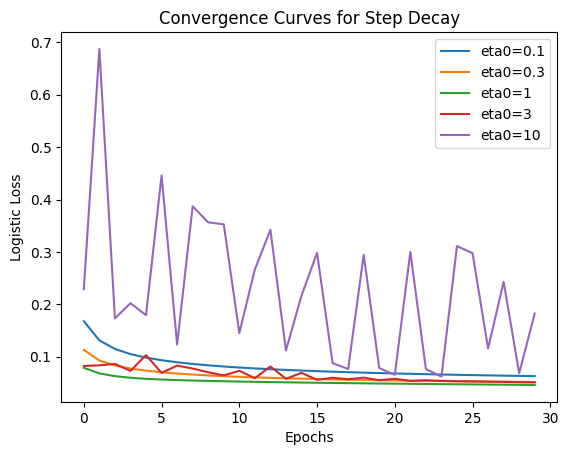

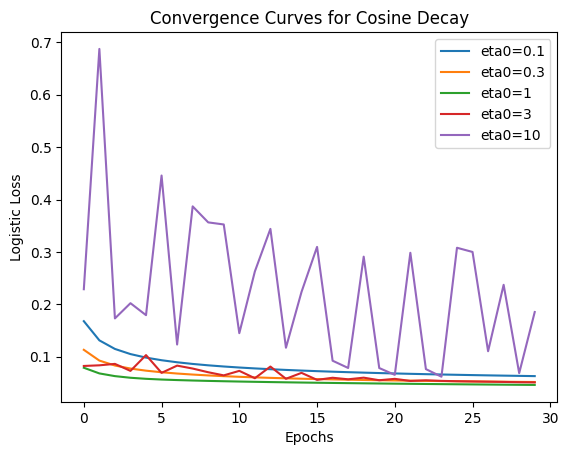

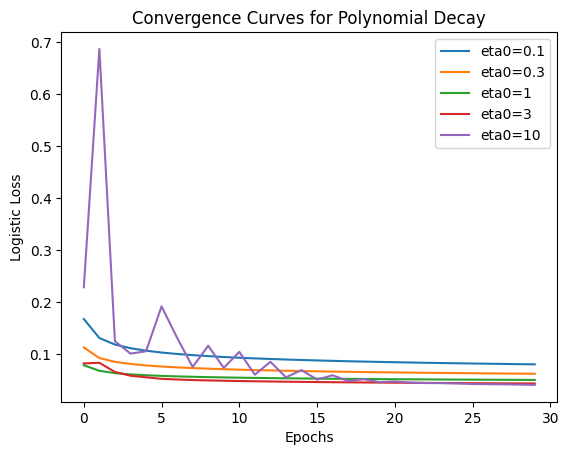

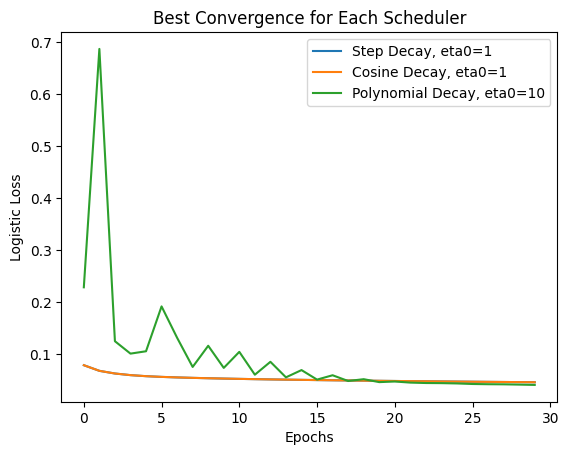

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
data = load_breast_cancer()
X, y = data.data, data.target
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}
X = StandardScaler().fit_transform(X)  # Standardize features
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression objective function
def logistic_loss(w, X, y):
    return np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))

# SGD with different learning rate schedulers
def sgd(X, y, epochs, batch_size, lr_scheduler, eta0, **kwargs):
    n, d = X.shape
    w = np.zeros(d)  # Initialize weights
    losses = []
    
    for epoch in range(epochs):
        for i in range(0, n, batch_size):
            Xi = X[i:i + batch_size]
            yi = y[i:i + batch_size]
            grad = -np.dot(yi * np.exp(-yi * np.dot(Xi, w)) / (1 + np.exp(-yi * np.dot(Xi, w))), Xi)
            eta = lr_scheduler(epoch, eta0, **kwargs)
            w -= eta * grad / batch_size
        losses.append(logistic_loss(w, X, y))
    
    return w, losses


# Hyperparameters
epochs = 30
batch_size = 16
initial_lrs = [0.1, 0.3, 1, 3, 10]     # Initial learning rate (can be tuned)
eta_min = 0.001  # Minimum learning rate
iterations_per_epoch = np.ceil(len(train_X) / batch_size)
t0 = 15 * iterations_per_epoch  # Learning rate decays every 15 epochs
alpha = 0.5      # Decay exponent
gamma = 0.1
T = epochs * iterations_per_epoch #total number of iterations

# Step decay scheduler
def step_decay(t, eta0, gamma=0.1, t0=t0):
    if(t<= 0):
        return eta0
    return eta0 * gamma ** (t // t0)
    

# Cosine decay scheduler
def cosine_decay(t, eta0, eta_min=0.001, T=T):
    if(t<= 0):
        return eta0
    return eta_min + 0.5 * (eta0 - eta_min) * (1 + np.cos(t * np.pi / T))

# Polynomial decay scheduler
def polynomial_decay(t, eta0, alpha=0.5):
    if(t<= 0):
        return eta0
    return eta0 / (t ** alpha)



# Running SGD for different schedulers
schedulers = {'Step Decay': step_decay, 'Cosine Decay': cosine_decay, 'Polynomial Decay': polynomial_decay}
results = {}

for name, scheduler in schedulers.items():
    for eta0 in initial_lrs:
        _, losses = sgd(train_X, train_y, epochs, batch_size, scheduler, eta0)
        results[(name, eta0)] = losses

# Plot convergence curves for each scheduler and learning rate
for name, scheduler in schedulers.items():
    plt.figure()
    for eta0 in initial_lrs:
        plt.plot(results[(name, eta0)], label=f'eta0={eta0}')
    plt.title(f'Convergence Curves for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Logistic Loss')
    plt.legend()
    plt.show()

# Compare the best convergence curves for each scheduler
plt.figure()
for name in schedulers.keys():
    best_eta0 = min(initial_lrs, key=lambda lr: results[(name, lr)][-1])
    plt.plot(results[(name, best_eta0)], label=f'{name}, eta0={best_eta0}')
plt.title('Best Convergence for Each Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.legend()
plt.show()


Start Training with step_decay scheduler and initial_lr=0.1
------------------------------
Final Train Loss with step_decay: 0.0761
Start Training with cosine_decay scheduler and initial_lr=0.1
------------------------------
Final Train Loss with cosine_decay: 0.0776
Start Training with polynomial_decay scheduler and initial_lr=0.1
------------------------------
Final Train Loss with polynomial_decay: 0.0764
Start Training with step_decay scheduler and initial_lr=0.3
------------------------------
Final Train Loss with step_decay: 0.0760
Start Training with cosine_decay scheduler and initial_lr=0.3
------------------------------
Final Train Loss with cosine_decay: 0.0766
Start Training with polynomial_decay scheduler and initial_lr=0.3
------------------------------
Final Train Loss with polynomial_decay: 0.0764
Start Training with step_decay scheduler and initial_lr=1
------------------------------
Final Train Loss with step_decay: 0.0782
Start Training with cosine_decay scheduler and

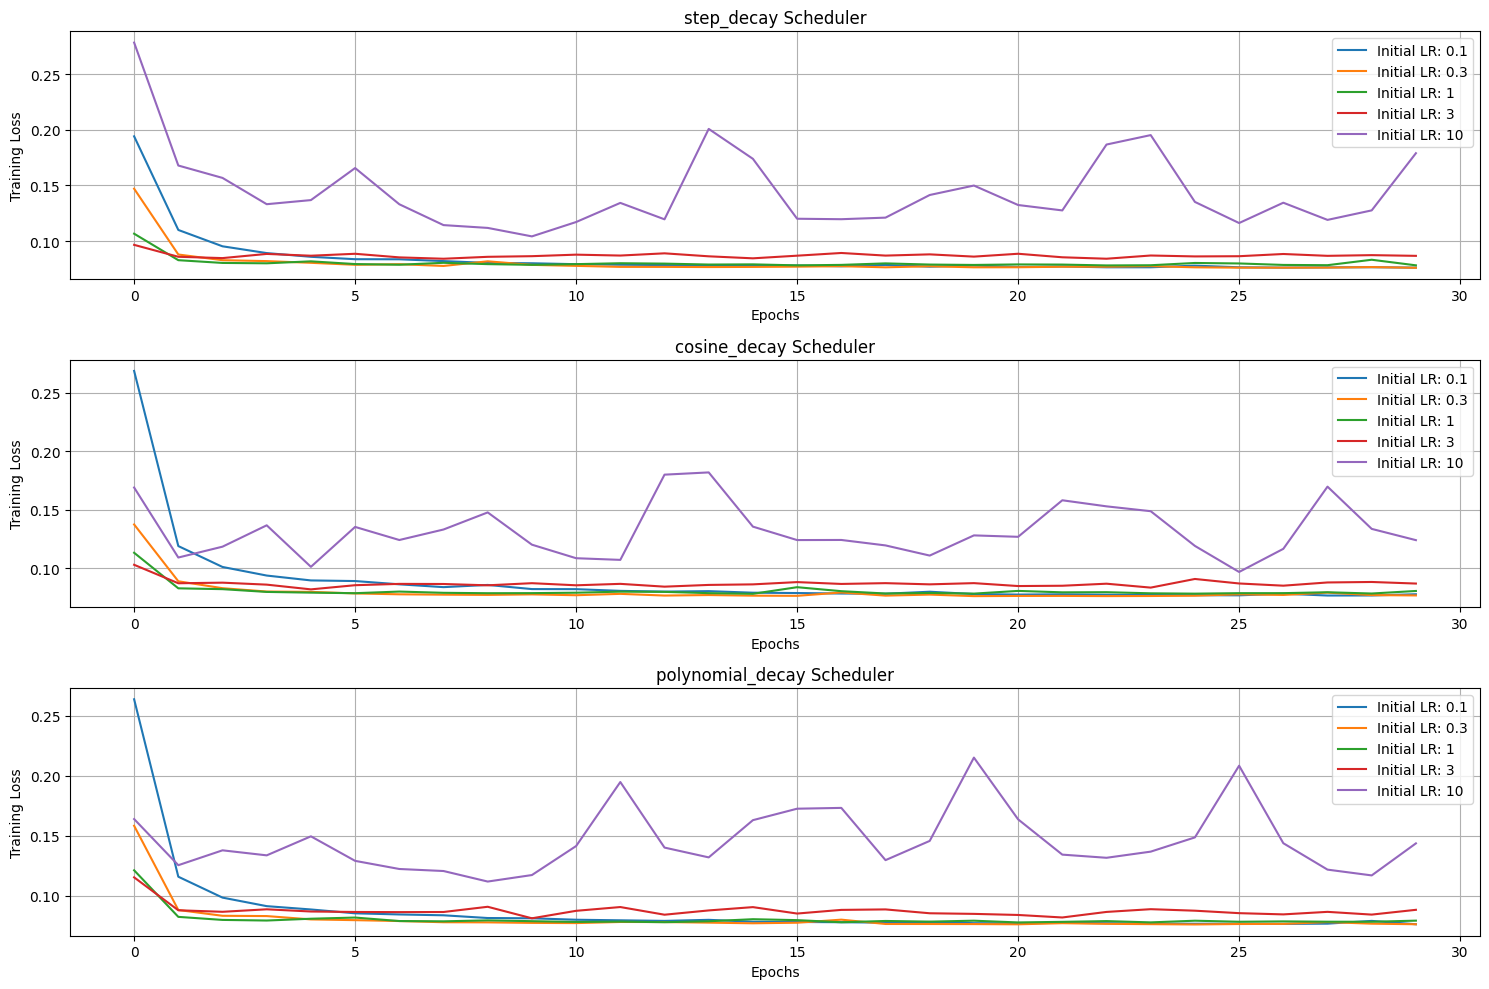

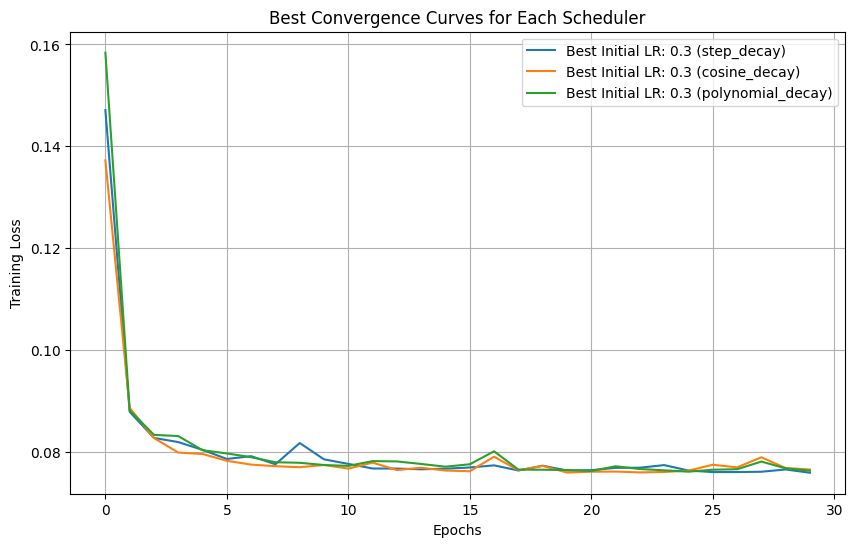

In [10]:
from libauc.losses import CrossEntropyLoss

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import top_k_accuracy_score
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

class LibSVMDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.targets[targets == 2] = 0  # convert 2 to 0 for breast-cancer dataset only
        self.targets[targets == 4] = 1  # convert 4 to 1 for breast-cancer dataset only

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.data[idx].astype(np.float32)
        target = self.targets[idx].astype(np.int64)
        return data, target

class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.1, weight_decay=0.0):
        self.lr = lr
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            self.lr = group['lr']
            for p in group['params']:
                d_p = p.grad
                p.data -= self.lr * d_p + weight_decay * p.data

class LinearModel(torch.nn.Module):
    def __init__(self, input_dim=10, output_dim=1):
        super().__init__()
        self.classifier = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.classifier(x)

# Hyper Parameters
BATCH_SIZE = 16
total_epochs = 30
learning_rates = [0.1, 0.3, 1, 3, 10]
eta_min = 0.001
step_gamma = 0.1
alpha = 0.5

def main():
    # Load data
    X_train, y_train = load_svmlight_file("breast-cancer_scale")
    
    # Normalization
    scaler = StandardScaler()
    X_train = X_train.toarray()
    X_train = scaler.fit_transform(X_train)

    # Dataset and dataloaders
    trainSet = LibSVMDataset(X_train, y_train)
    trainloader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)

    num_iterations = total_epochs * (len(trainSet) // BATCH_SIZE)

    # Prepare for plotting
    train_logs = {scheduler: {lr: [] for lr in learning_rates} for scheduler in ['step_decay', 'cosine_decay', 'polynomial_decay']}
    best_convergence = {scheduler: (None, float('inf')) for scheduler in train_logs.keys()}  # (initial_lr, loss)

    for initial_lr in learning_rates:
        for scheduler in train_logs.keys():
            print(f'Start Training with {scheduler} scheduler and initial_lr={initial_lr}')
            print('-' * 30)

            # Reset model and optimizer for each learning rate and scheduler
            model = LinearModel(input_dim=X_train.shape[-1], output_dim=1)
            optimizer = SGD(model.parameters(), lr=initial_lr)

            for epoch in range(total_epochs):
                # Learning rate scheduling
                if scheduler == 'step_decay':
                    if epoch > 0 and epoch % 15 == 0:
                        optimizer.lr *= step_gamma

                elif scheduler == 'cosine_decay':
                    optimizer.lr = eta_min + 0.5 * (initial_lr - eta_min) * (1 + np.cos(epoch * np.pi / num_iterations))

                elif scheduler == 'polynomial_decay':
                    optimizer.lr = initial_lr * (1 - epoch / total_epochs) ** alpha

                # Training
                train_loss = []
                model.train()
                for data, targets in trainloader:
                    y_pred = model(data)
                    loss = CrossEntropyLoss()(y_pred, targets.float().reshape(-1, 1))
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_loss.append(loss.item())

                train_loss_mean = np.mean(train_loss)
                train_logs[scheduler][initial_lr].append(train_loss_mean)

                # Update best convergence
                if train_loss_mean < best_convergence[scheduler][1]:
                    best_convergence[scheduler] = (initial_lr, train_loss_mean)

            # Print final results for each initial learning rate and scheduler
            print(f"Final Train Loss with {scheduler}: {train_loss_mean:.4f}")

    # Plot the Training loss curves for each scheduler
    plt.figure(figsize=(15, 10))

    for scheduler in train_logs.keys():
        plt.subplot(3, 1, ['step_decay', 'cosine_decay', 'polynomial_decay'].index(scheduler) + 1)
        for lr, losses in train_logs[scheduler].items():
            plt.plot(losses, label=f'Initial LR: {lr}')
        plt.title(f'{scheduler} Scheduler')
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

    # Plot the best convergence curves in a single figure
    plt.figure(figsize=(10, 6))
    for scheduler, (best_lr, _) in best_convergence.items():
        plt.plot(train_logs[scheduler][best_lr], label=f'Best Initial LR: {best_lr} ({scheduler})')

    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Best Convergence Curves for Each Scheduler')
    plt.legend()
    plt.grid()
    plt.show()

main()
